In [82]:
# !pip isntall networkx==1.11
# !pip install seaborn==0.9.0
# !pip install lightgbm

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import random
from dateutil.parser import parse
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style(style = 'whitegrid')
c_palette = ['tab:blue', 'tab:orange']
np.seterr(divide = 'ignore') 
pd.options.mode.chained_assignment = None  # default='warn'

# Loading Data

In [2]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [3]:
df_train.head()

,runDate,stations,trainCode,trainStationId,scheduledArrival,scheduledDeparture,actualArrival,actualDeparture,distance,dayCount,ArrivalDelay,DepartureDelay
0,2020-01-01,FZR,12138,2657812,NaN,2020-01-01 21:40:00,2020-01-01 00:00:00,2020-01-01 21:40:00,0,0,0,0
1,2020-01-01,FDK,12138,2659393,2020-01-01 22:05:00,2020-01-01 22:07:00,2020-01-01 22:16:00,2020-01-01 22:18:00,32,0,11,11
2,2020-01-01,KKP,12138,2658108,2020-01-01 22:23:00,2020-01-01 22:25:00,2020-01-01 22:37:00,2020-01-01 22:38:00,45,0,14,13
3,2020-01-01,GJUT,12138,2734206,2020-01-01 22:38:00,2020-01-01 22:40:00,2020-01-01 22:56:00,2020-01-01 22:57:00,61,0,18,17
4,2020-01-01,GNA,12138,2742572,2020-01-01 22:54:00,2020-01-01 22:56:00,2020-01-01 23:14:00,2020-01-01 23:15:00,76,0,20,19


In [4]:
df_test.head()

,runDate,stations,trainId,trainCode,index,trainStationId,scheduledArrival,scheduledDeparture,distance,dayCount,day
0,2020-02-20,FZR,11528,12138,1,2657812,NaN,2020-02-20 21:40:00,0,0,Thursday
1,2020-02-20,FDK,11528,12138,2,2659393,2020-02-20 22:05:00,2020-02-20 22:07:00,32,0,Thursday
2,2020-02-20,KKP,11528,12138,3,2658108,2020-02-20 22:23:00,2020-02-20 22:25:00,45,0,Thursday
3,2020-02-20,GJUT,11528,12138,4,2734206,2020-02-20 22:38:00,2020-02-20 22:40:00,61,0,Thursday
4,2020-02-20,GNA,11528,12138,5,2742572,2020-02-20 22:54:00,2020-02-20 22:56:00,76,0,Thursday


In [5]:
df_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31875 entries, 0 to 31874
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   runDate             31875 non-null  object
 1   stations            31875 non-null  object
 2   trainCode           31875 non-null  int64 
 3   trainStationId      31875 non-null  int64 
 4   scheduledArrival    31184 non-null  object
 5   scheduledDeparture  31097 non-null  object
 6   actualArrival       31875 non-null  object
 7   actualDeparture     31775 non-null  object
 8   distance            31875 non-null  int64 
 9   dayCount            31875 non-null  int64 
 10  ArrivalDelay        31875 non-null  int64 
 11  DepartureDelay      31875 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 2.9+ MB


In [6]:
# pd.options.display.max_info_rows
df_test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 695 entries, 0 to 694
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   runDate             695 non-null    object
 1   stations            695 non-null    object
 2   trainId             695 non-null    int64 
 3   trainCode           695 non-null    int64 
 4   index               695 non-null    int64 
 5   trainStationId      695 non-null    int64 
 6   scheduledArrival    680 non-null    object
 7   scheduledDeparture  678 non-null    object
 8   distance            695 non-null    int64 
 9   dayCount            695 non-null    int64 
 10  day                 695 non-null    object
dtypes: int64(6), object(5)
memory usage: 59.9+ KB


# EDA

In [7]:
from pandas_profiling import ProfileReport

In [8]:
profile = ProfileReport(df_train, title='Profiling Report', explorative=True)

In [9]:
# profile.to_file("report.html")
profile.to_notebook_iframe()

# Utils

In [10]:
def date_parser(x, date_format):
    try:
        x = datetime.strptime(str(parse(x)), date_format)
        return x, True
    except ValueError:
        return x, False

def dates_to_duration(a, b, duration='day'):
    """
        Utility function to convert dates to duration
    """
    date_format=["%Y-%m-%d %H:%M:%S", "%Y-%m-%dT%H:%M:%S%z", "%Y-%m-%d %H:%M:%S.%f%z"]
    
    for i in date_format:
        p, result = date_parser(a, i)
        if result:
            break
            
    for i in date_format:
        q, result = date_parser(b, i)
        if result:
            break
    
    if duration == 'day':
        return abs((p - q).days)
    if duration == 'hour':
        return abs((p - q)).seconds / 3600
    elif duration == 'minute':
        return abs((p - q)).seconds / 60
    else:
        return abs((p - q)).seconds

In [11]:
def quantitative_summarized(dataframe, x=None, y=None, hue=None, palette='Set1', ax=None, verbose=False, swarm=False):
    """
        Utility function to print summary of a numeric column
    """
    series = dataframe[y]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())

    sns.boxplot(x=x, y=y, hue=hue, data=dataframe, palette=palette, ax=ax)

    if swarm:
        sns.swarmplot(x=x, y=y, hue=hue, data=dataframe,
                      palette=palette, ax=ax)

    plt.show()

In [12]:
def categorical_summarized(dataframe, x=None, y=None, hue=None, palette='Set1', verbose=False):
    """
        Utility function to print summary of a categorical column
    """
    if x == None:
        column_interested = y
    else:
        column_interested = x
    series = dataframe[column_interested]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())

    sns.countplot(x=x, y=y, hue=hue, data=dataframe, palette=palette)
    plt.show()

In [13]:
# quantitative_summarized(df_cleaned, y = 'quantity', palette=c_palette)
# categorical_summarized(df_cleaned, y = 'status', palette=c_palette)

# Data Preprocessing and Cleaning

In [14]:
# sorting the rows based on trainCode and runDate
df_train = df_train.sort_values(by=['trainCode', 'runDate']).drop_duplicates()
df_test = df_test.sort_values(by=['trainCode', 'runDate']).drop_duplicates()

In [15]:
df_train.head()

,runDate,stations,trainCode,trainStationId,scheduledArrival,scheduledDeparture,actualArrival,actualDeparture,distance,dayCount,ArrivalDelay,DepartureDelay
0,2020-01-01,FZR,12138,2657812,NaN,2020-01-01 21:40:00,2020-01-01 00:00:00,2020-01-01 21:40:00,0,0,0,0
1,2020-01-01,FDK,12138,2659393,2020-01-01 22:05:00,2020-01-01 22:07:00,2020-01-01 22:16:00,2020-01-01 22:18:00,32,0,11,11
2,2020-01-01,KKP,12138,2658108,2020-01-01 22:23:00,2020-01-01 22:25:00,2020-01-01 22:37:00,2020-01-01 22:38:00,45,0,14,13
3,2020-01-01,GJUT,12138,2734206,2020-01-01 22:38:00,2020-01-01 22:40:00,2020-01-01 22:56:00,2020-01-01 22:57:00,61,0,18,17
4,2020-01-01,GNA,12138,2742572,2020-01-01 22:54:00,2020-01-01 22:56:00,2020-01-01 23:14:00,2020-01-01 23:15:00,76,0,20,19


In [16]:
# convert trainCode to str
df_train['trainCode'] = df_train['trainCode'].apply(str)
df_test['trainCode'] = df_test['trainCode'].apply(str)

In [17]:
# Calculate travel duration in hours
df_train['actualTravelDuration'] = df_train[['scheduledDeparture', 'scheduledArrival']].apply(lambda x: dates_to_duration(x.scheduledDeparture, x.scheduledArrival, duration='hour') if all(pd.notnull([x.scheduledDeparture, x.scheduledArrival])) else 0, axis=1)
df_test['actualTravelDuration'] = df_test[['scheduledDeparture', 'scheduledArrival']].apply(lambda x: dates_to_duration(x.scheduledDeparture, x.scheduledArrival, duration='hour') if all(pd.notnull([x.scheduledDeparture, x.scheduledArrival])) else 0, axis=1)

## Handling Missing Values & Categorical Cols

In [18]:
cols_to_process_train = ['stations', 'trainCode', 'distance', 'dayCount', 'ArrivalDelay',
                           'DepartureDelay', 'actualTravelDuration']
cols_to_process_test = ['stations', 'trainCode', 'distance', 'dayCount', 'actualTravelDuration']
df_train = df_train[cols_to_process_train]
df_test = df_test[cols_to_process_test]

In [19]:
df_train[df_train.select_dtypes(include=['int64']).columns].fillna(0, inplace=True)
df_train[df_train.select_dtypes(include=['object']).columns].fillna('unattributed', inplace=True)
df_train = pd.get_dummies(df_train, columns=df_train.select_dtypes(include=['object']).columns)

df_test[df_test.select_dtypes(include=['int64']).columns].fillna(0, inplace=True)
df_test[df_test.select_dtypes(include=['object']).columns].fillna('unattributed', inplace=True)
df_test = pd.get_dummies(df_test, columns=df_test.select_dtypes(include=['object']).columns)

## Data Preparation

In [20]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

In [21]:
robust_scaler = RobustScaler() 
minmax_scaler = MinMaxScaler() 

In [22]:
df_train['distance'] = robust_scaler.fit_transform(np.array(df_train['distance']).reshape(-1, 1))
df_test['distance'] = robust_scaler.fit_transform(np.array(df_test['distance']).reshape(-1, 1))

In [23]:
# sort a dataframe based on column names 
df_train = df_train.sort_index(axis = 1) 
df_test = df_test.sort_index(axis = 1) 

In [24]:
X = df_train.drop(['ArrivalDelay', 'DepartureDelay'], axis=1)
y = df_train[['ArrivalDelay', 'DepartureDelay']]

In [25]:
train_columns = list(df_train.columns)
train_columns.remove('ArrivalDelay')
train_columns.remove('DepartureDelay')

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.10, random_state = 123, shuffle=True)

# Delay Estimation

In [27]:
# self-defined eval metric
# f(y_true: array, y_pred: array) -> name: string, eval_result: float, is_higher_better: bool
# Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y_true, y_pred):
    return 'RMSLE', np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))), False

# f(y_true: array, y_pred: array) -> name: string, eval_result: float, is_higher_better: bool
# Relative Absolute Error (RAE)
def rae(y_true, y_pred):
    return 'RAE', np.sum(np.abs(y_pred - y_true)) / np.sum(np.abs(np.mean(y_true) - y_true)), False

## RandomForestRegressor

In [37]:
import os
import joblib
import matplotlib.pyplot as plt

# Feature Importance by Tree-based estimators
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.model_selection import RepeatedKFold

## Hyperparameter Tuning

In [29]:
def hyperparameterOptimizationRFR(X, y):
    # RandomizedSearchCV
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 100)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(1, 10, num = 2)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2,4,7]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    rf = RandomForestRegressor()
    # Random search of parameters, using 3 fold cross validation,
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 25, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(X,  y)
    return rf_random

In [31]:
# Getting the best hyper parameters
hp = hyperparameterOptimizationRFR(X_train,  y_train)
hp = hp.best_params_
print('Best hyperparameters:', hp)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  9.2min finished


Best hyperparameters: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}


## Training

In [32]:
# Parameter values
regressor = RandomForestRegressor(n_estimators = hp['n_estimators'],min_samples_split = hp['min_samples_split'],
                                       min_samples_leaf = hp['min_samples_leaf'], max_features = hp['max_features'],
                                       max_depth = hp['max_depth'], bootstrap = hp['bootstrap'], n_jobs=-1)
wrapper = MultiOutputRegressor(regressor, n_jobs=-1)

# Fitting RFR to the Training set
regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=4, n_estimators=400,
                      n_jobs=-1)

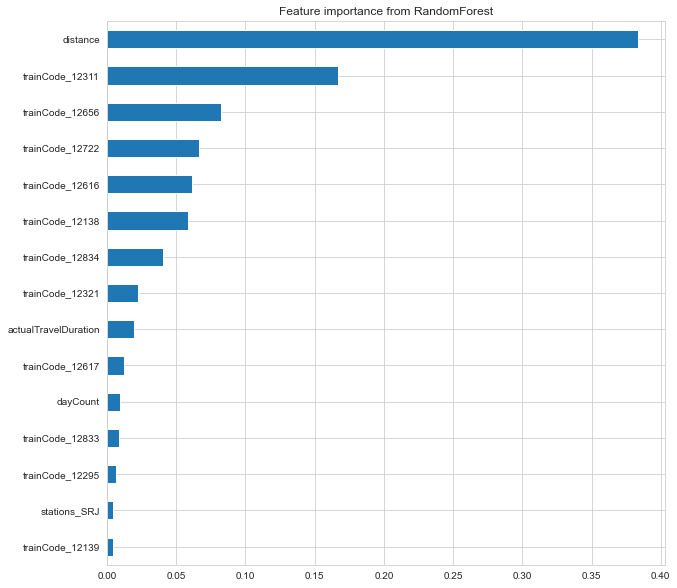

In [33]:
# Top 15 most weighted features
pd.Series(regressor.feature_importances_, index = df_test.columns).nlargest(15).plot(kind = 'barh',
                                                                                      figsize = (10, 10),
                                                                                      title = 'Feature importance from RandomForest').invert_yaxis()

In [34]:
wrapper = MultiOutputRegressor(regressor)
# Fitting MultiOutputRegressor to the Training set
wrapper.fit(X_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=10,
                                                     min_samples_leaf=4,
                                                     n_estimators=400,
                                                     n_jobs=-1))

### Prediction and Evaluation

In [35]:
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(wrapper, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = np.absolute(n_scores)
# summarize performance
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

MAE: 30.342 (0.805)


In [38]:
print('Starting predicting...')
# predict
y_pred = wrapper.predict(X_val)
# eval
print('The rmse of prediction is:', mean_squared_error(y_val, y_pred) ** 0.5)
print('\nThe rmsle of prediction is:\n', rmsle(y_val, y_pred)[1])
print('\nThe rae of prediction is:\n', rae(y_val, y_pred)[1])

Starting predicting...
The rmse of prediction is: 53.99976016877734

The rmsle of prediction is:
 ArrivalDelay           inf
DepartureDelay    1.369191
dtype: float64

The rae of prediction is:
 ArrivalDelay      0.789378
DepartureDelay    0.779087
dtype: float64


/home/rishab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log1p
  """


## LightGBM

In [39]:
# coding: utf-8
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

In [48]:
print('Starting training...')
estimator = lgb.LGBMRegressor(random_state=101)

param_grid ={
             'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
            }
    
# Random search of parameters, using 3 fold cross validation,
gbm = RandomizedSearchCV(
                estimator=estimator, param_distributions=param_grid, 
                n_iter=25,
                cv=3,
                random_state=314,
                refit=True,
                verbose=True,
                n_jobs = -1)

# Fit the random search model
model = MultiOutputRegressor(gbm, n_jobs=-1)
result = model.fit(X_train, y_train)

print('Starting completed!')

Starting training...
Starting completed!


### Prediction and Evaluation

In [49]:
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = np.absolute(n_scores)
# summarize performance
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

MAE: 30.065 (0.842)


In [50]:
print('Starting predicting...')
# predict
y_pred = model.predict(X_val)
# eval
print('The rmse of prediction is:', mean_squared_error(y_val, y_pred) ** 0.5)
print('\nThe rmsle of prediction is:\n', rmsle(y_val, y_pred)[1])
print('\nThe rae of prediction is:\n', rae(y_val, y_pred)[1])

Starting predicting...
The rmse of prediction is: 53.46490740487064

The rmsle of prediction is:
 ArrivalDelay           inf
DepartureDelay    1.360037
dtype: float64

The rae of prediction is:
 ArrivalDelay      0.778196
DepartureDelay    0.770339
dtype: float64


/home/rishab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log1p
  """
